# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jittered'
syn_data_type = 'jitter'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_11_lstm_unscaled.csv', shape=(28499, 12, 11))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_11_gru_unscaled.csv', shape=(28499, 12, 11))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [6]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
0,55.932045,288.773086,0.106505,0.00000,6.861281
1,265.637966,289.964299,0.094722,0.00000,0.225959
2,0.000000,290.510156,0.265676,0.00027,0.654357
3,870.705495,287.743104,0.020543,0.00000,0.000000
4,3067.613827,288.150558,0.076565,0.00000,3.452064


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [7]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 1,
    "num_epochs": 20,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [8]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  1
num_epochs :  20
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.06443146942183375
Training Loss: 0.060591116044670344
Training Loss: 0.057699061520397665
Validation Loss: 0.051570009733184
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.052356488984078166
Training Loss: 0.048464969992637635
Training Loss: 0.044801663355901834
Validation Loss: 0.037881433231274735
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03875394245609641
Training Loss: 0.034640139490365984
Training Loss: 0.03133233761414886
Validation Loss: 0.024780172247732622
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.026509538674727082
Training Loss: 0.02414374157320708
Training Loss: 0.022713941633701325
Validation Loss: 0.018261143477277808
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.02030864258762449
Training Loss: 0.019551341822370887
Tra

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_evaluation/predictive_evaluation.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
100%|██████████| 1/1 [00:22<00:00, 22.69s/it]


Validation Loss: 0.00636125530712725
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.075274538975209
Training Loss: 0.07119686787948012
Training Loss: 0.06913620427250862
Validation Loss: 0.06824680221047294
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06709134843200446
Training Loss: 0.06360156770795583
Training Loss: 0.061027068756520746
Validation Loss: 0.05915122368278798
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05793657781556249
Training Loss: 0.054117024820297954
Training Loss: 0.05142441621050239
Validation Loss: 0.04936278244124705
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04843464757315814
Training Loss: 0.044987525986507536
Training Loss: 0.0426630044542253
Validation Loss: 0.04070500598362323
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04008938567712903
Training Loss: 0.03707890830934048
Training Loss

100%|██████████| 1/1 [00:22<00:00, 22.46s/it]


Validation Loss: 0.005876764558318458
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.84343421459198
Training Loss: 0.6461578583717347
Training Loss: 0.4870267802476883
Validation Loss: 0.3661852198537816
Validation Accuracy: 0.5467495987158908
**************************************************
Epoch: 2
Training Loss: 0.30705878108739854
Training Loss: 0.2068505111336708
Training Loss: 0.13361111160367728
Validation Loss: 0.09416074184386918
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08093391647562384
Training Loss: 0.07149598259478808
Training Loss: 0.06866886077448725
Validation Loss: 0.06824353452395188
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06539893938228487
Training Loss: 0.06546672558411956
Training Loss: 0.06461609963327647
Validation Loss: 0.06459871679544449
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.061699101589620116
Training Loss: 0.06108928849920631
Trai

100%|██████████| 1/1 [00:22<00:00, 22.37s/it]


Validation Loss: 0.008823691422559237
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.1997982342913747
Training Loss: 0.14594671368598938
Training Loss: 0.09919929910451174
Training Loss: 0.07414452748373151
Training Loss: 0.06768872318789362
Training Loss: 0.06646159119904041
Training Loss: 0.06363206643611193
Validation Loss: 0.06328731178121173
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06208734918385744
Training Loss: 0.060565694868564605
Training Loss: 0.05849751342087984
Training Loss: 0.05612430533394217
Training Loss: 0.05466442793607712
Training Loss: 0.05372774105519056
Training Loss: 0.05041639119386673
Validation Loss: 0.04887516541260012
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0476474211551249
Training Loss: 0.04484447035938501
Training Loss: 0.04253463151864707
Training Loss: 0.03985694975592196
Training Loss: 0.037725958209484815
Training Loss: 0.03674710612744093
Training Loss: 0.03389389643445611
Validation L

100%|██████████| 1/1 [00:43<00:00, 43.98s/it]

Training Loss: 0.008281388384057209
Validation Loss: 0.005624183622792308
Validation Accuracy: 0.04681647940074907
**************************************************


In [9]:
results.shape

(8, 3)

In [10]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [11]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

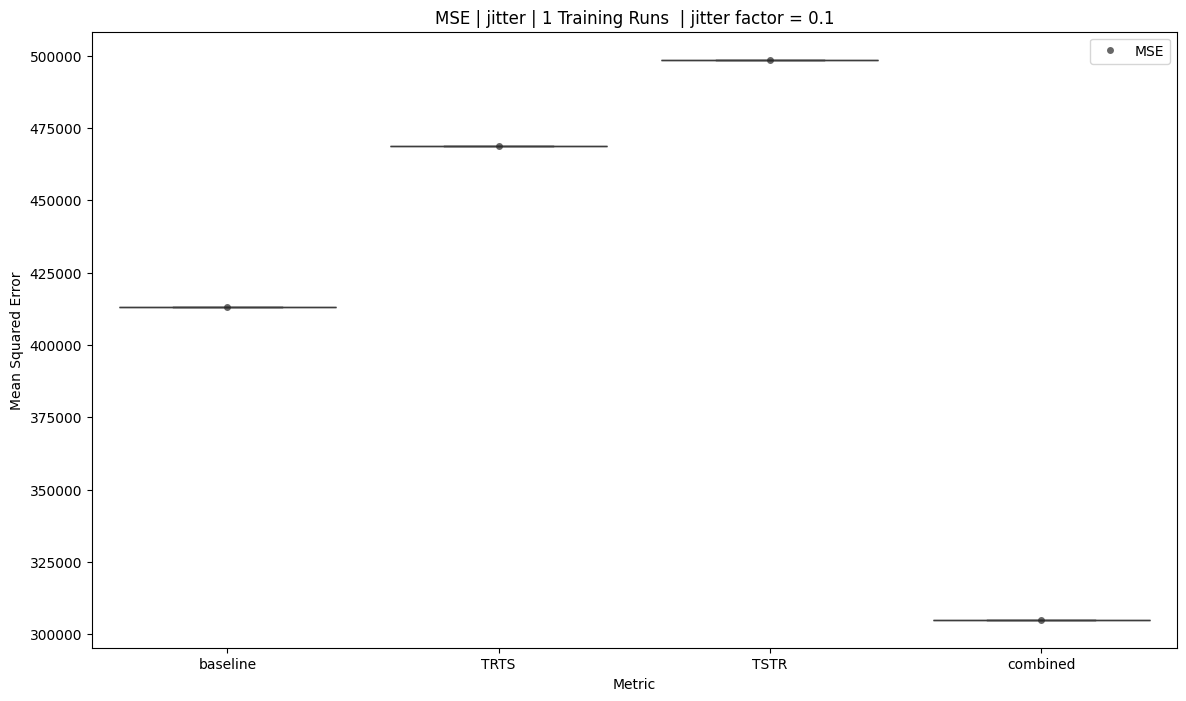

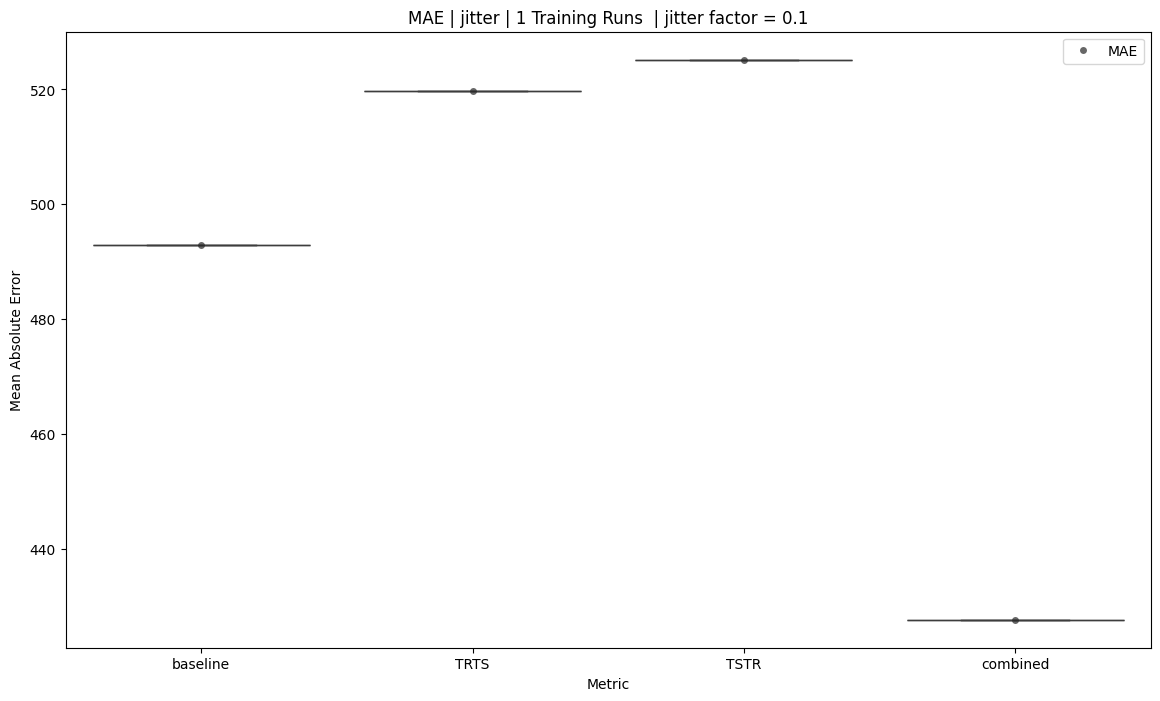

In [12]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Visualize Synthetic vs Real Data

In [13]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)


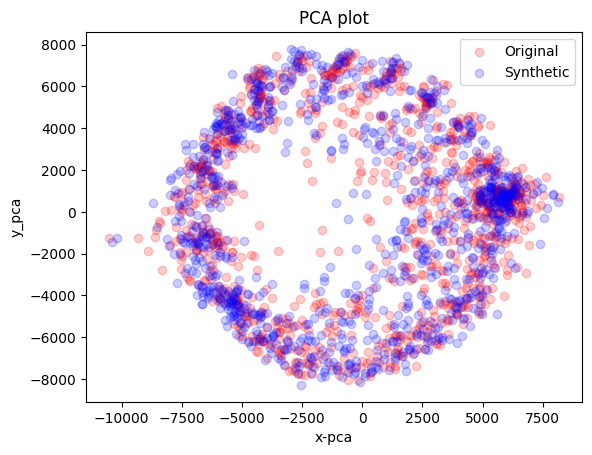

Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.123s...


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1104.005719
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.993114
[t-SNE] KL divergence after 300 iterations: 0.922275


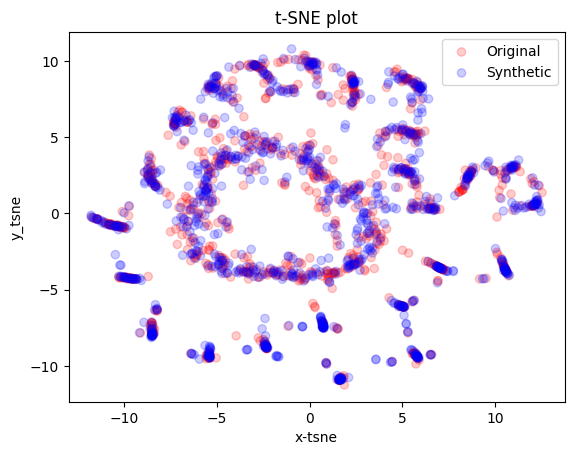

In [14]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.